In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.impute   import SimpleImputer
import optuna
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics  import roc_auc_score


Importo en un dataframe la cohorte de datos

In [3]:
df_data = pd.read_csv('./data/data.csv', sep = ";")
df_data.index.name = 'idMuestra'
df_data.head(3)

,IDInm,NH,AntiN,AntiS,AntiM,age,gender,score,Line Timepoint,Timepoint,...,TH27p28n,TH27n28n,CTLDRn38n,CTLDRp38n,CTLDRn38p,CTLDRp38p,THDRn38n,THDRp38n,THDRn38p,THDRp38
idMuestra,,,,,,,,,,,,,,,,,,,,,
0,1407962,3084327,NaN,NaN,NaN,88,1,NaN,NaN,0.0,...,0.007514,0.037952,0.075808,0.064660,0.638796,0.220736,0.046994,0.024834,0.879776,0.048395
1,1407963,587116,NaN,NaN,NaN,46,0,NaN,NaN,0.0,...,0.001384,0.000951,0.057471,0.014049,0.826309,0.102171,0.035378,0.003979,0.938587,0.022057
2,1408025,764584,NaN,NaN,NaN,82,0,3.0,1.0,1.0,...,0.027458,0.085781,0.232804,0.037037,0.221164,0.508995,0.255428,0.018838,0.628991,0.096743


En el trabajo que vamos a replicar, se escogen los datos entre Abril y Octubre de 2020 y que hayan dado positivo en prueba PCR. Además descartamos los que no tienen score.

In [4]:
df_datos = df_data.copy()

# Descartamos los datos nulos o vacíos en el campo "score"
df_datos = df_datos[~df_datos[df_datos.columns[7]].isnull()]

# Descartamos los datos nulos o vacíos en el campo "fechaPCRpos" o los que son negativos "NEG"
df_datos = df_datos[~df_datos[df_datos.columns[19]].isnull()]
df_datos = df_datos[df_datos['fechaPCRpos'] != 'NEG']

# Escogemos los datos entre Abril y Octubre 2020
df_datos['fechaPCRpos'] = df_datos['fechaPCRpos'].astype('int64')
fechas = pd.to_datetime(df_datos['fechaPCRpos'], unit='D', origin='1899-12-30')
df_datos['FechaPCR'] = fechas
df_datos = df_datos[df_datos['FechaPCR'] < '2020-11-01']

Escojo las variables que quiero utilizar y las meto en otro dataframe

In [5]:
df_datos = df_datos.drop(['IDInm', 'NH','Line Timepoint','Timepoint','fechaAnalisis','fechaInicioSintomas',
               'fechaPCRpos','fechaIngreso','fechaIngresoUCI','fechaAltaUCI','fechaAlta','fechaExitus','FechaPCR'], axis = 1)
df_datos.head(3)

,AntiN,AntiS,AntiM,age,gender,score,IL6,ferritina,troponina,LDH,...,TH27p28n,TH27n28n,CTLDRn38n,CTLDRp38n,CTLDRn38p,CTLDRp38p,THDRn38n,THDRp38n,THDRn38p,THDRp38
idMuestra,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,82,0,3.0,48.6,328.0,153.0,548.0,...,0.027458,0.085781,0.232804,0.037037,0.221164,0.508995,0.255428,0.018838,0.628991,0.096743
3,NaN,NaN,NaN,72,0,4.0,NaN,833.0,7.0,305.0,...,0.004097,0.134451,0.415865,0.016827,0.439904,0.127404,0.584730,0.035009,0.307635,0.072626
4,NaN,NaN,NaN,51,0,1.0,NaN,1261.0,16.0,254.0,...,0.005607,0.001869,0.464220,0.060550,0.365138,0.110092,0.400000,0.036582,0.538318,0.025100


In [6]:
feature_names = df_datos.drop(columns = 'score').columns.values

Compruebo el número de nulos (NaN) de cada variable

In [7]:
df_datos.isnull().sum()

AntiN        70
AntiS        70
AntiM        70
age           0
gender        0
             ..
CTLDRp38p    16
THDRn38n     17
THDRp38n     17
THDRn38p     17
THDRp38      17
Length: 85, dtype: int64

<Axes: ylabel='idMuestra'>

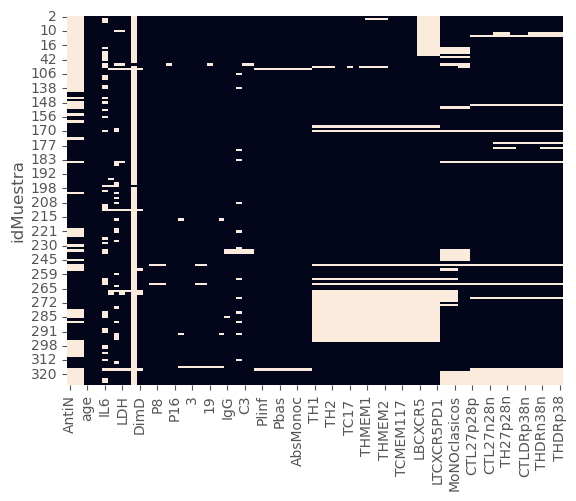

In [8]:
# Identificamos los valores NaN visualmente
sns.heatmap(df_datos.isnull(), cbar=False)

Creo otro dataframe con el score sin valores nulos (NaN)

Convierto la multivariable score en 2 variables: 0 Leve y 1 Moderado/Severo

In [9]:
df_datos['score'] = np.where(df_datos['score'] > 1, 1, 0)

print("Número de observaciones por clase")
print(df_datos['score'].value_counts())
print("")

print("Porcentaje de observaciones por clase")
print(100 * df_datos['score'].value_counts(normalize=True))

Número de observaciones por clase
score
1    82
0    73
Name: count, dtype: int64

Porcentaje de observaciones por clase
score
1    52.903226
0    47.096774
Name: proportion, dtype: float64


Creo los dataframes de entrenamiento (X) y de test (y)

In [10]:
# Imputamos media
mean_impute  = SimpleImputer(strategy='mean')
imputed_data = mean_impute.fit_transform(df_datos)
imputed_data = pd.DataFrame(imputed_data, columns = df_datos.columns)

In [11]:
X = imputed_data.drop(columns = 'score').to_numpy()
y = imputed_data['score'].to_numpy()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1, stratify=y)

In [13]:
# Definición de la función objetivo para Optuna
def objective(trial):
    # Definición de los hiperparámetros a ajustar
    solver = trial.suggest_categorical("solver", ["lsqr", "eigen"])
    shrinkage = trial.suggest_float("shrinkage", 0, 1)
    tol = trial.suggest_float("tol", 0, 1)

    # Creación del modelo LDA con los hiperparámetros sugeridos por Optuna
    model = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage, tol=tol)

    # Ajuste del modelo en el conjunto de entrenamiento
    model.fit(X_train, y_train)

    # Evaluación del modelo en el conjunto de prueba
    #accuracy = model.score(X_test, y_test)
    #return accuracy

    y_pred = model.predict_proba(X_test)
    roc = roc_auc_score(y_test, y_pred[:,1])
    return roc

In [14]:
study = optuna.create_study(direction='maximize') # maximize accuracy
study.optimize(objective, n_trials=100)

[I 2023-07-05 12:00:44,055] A new study created in memory with name: no-name-e8ff0179-9c31-4a1e-bed1-f68add1987ae
[I 2023-07-05 12:00:44,081] Trial 0 finished with value: 0.7791666666666667 and parameters: {'solver': 'lsqr', 'shrinkage': 0.9702786065698773, 'tol': 0.5823770465113083}. Best is trial 0 with value: 0.7791666666666667.
[I 2023-07-05 12:00:44,104] Trial 1 finished with value: 0.5791666666666667 and parameters: {'solver': 'lsqr', 'shrinkage': 0.060960199335148624, 'tol': 0.24934344011031762}. Best is trial 0 with value: 0.7791666666666667.
[I 2023-07-05 12:00:44,136] Trial 2 finished with value: 0.7 and parameters: {'solver': 'eigen', 'shrinkage': 0.6120361809989305, 'tol': 0.9228286923872107}. Best is trial 0 with value: 0.7791666666666667.
[I 2023-07-05 12:00:44,159] Trial 3 finished with value: 0.6291666666666667 and parameters: {'solver': 'eigen', 'shrinkage': 0.310661581837096, 'tol': 0.4521494910017009}. Best is trial 0 with value: 0.7791666666666667.
[I 2023-07-05 12:

In [15]:
# Obtención de los mejores hiperparámetros encontrados
best_trial = study.best_trial
print("Mejores hiperparámetros encontrados:", best_trial.params)

Mejores hiperparámetros encontrados: {'solver': 'lsqr', 'shrinkage': 0.9114542283885831, 'tol': 0.5143735670828984}


In [16]:
# Ajuste del modelo con los mejores hiperparámetros encontrados
best_model = LinearDiscriminantAnalysis(**best_trial.params)
best_model.fit(X_train, y_train)

LinearDiscriminantAnalysis(shrinkage=0.9114542283885831, solver='lsqr',
                           tol=0.5143735670828984)

In [17]:
# Evaluación del modelo en el conjunto de prueba
print("Exactitud del modelo en el conjunto de prueba:", round(best_trial.value * 100, 2), '%')

Exactitud del modelo en el conjunto de prueba: 78.75 %


In [18]:
# Extraemos los valores de Shap
explainer   = shap.explainers.Linear(best_model, X_train)
shap_values = explainer.shap_values(X_train)

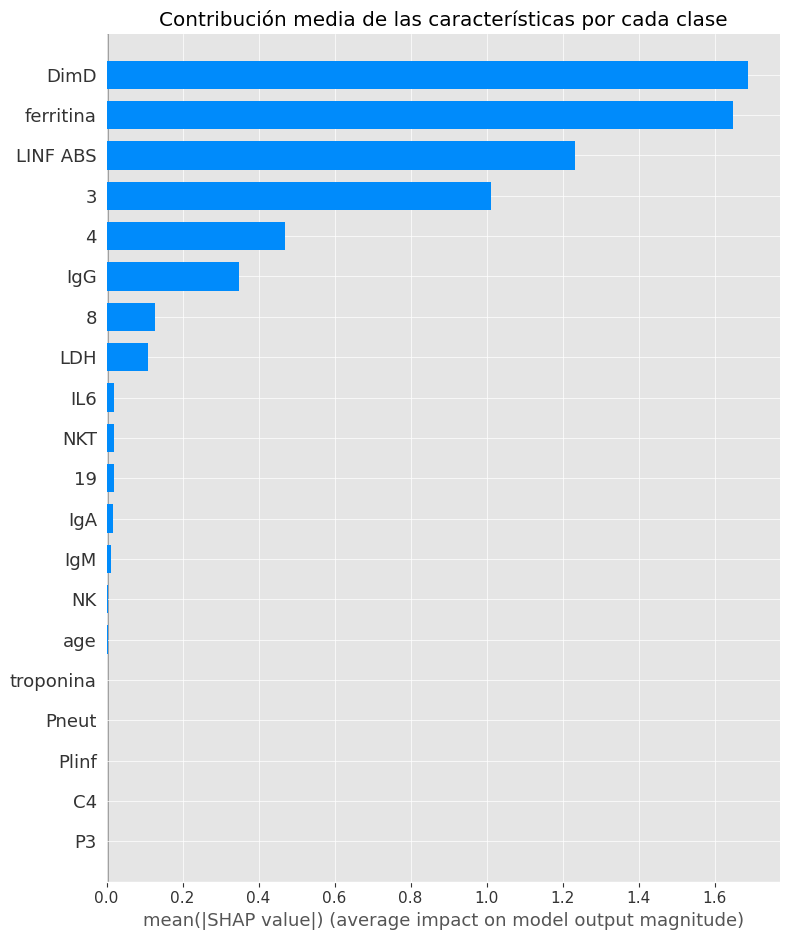

In [19]:
# Contribución media de las características por cada clase
plt.title('Contribución media de las características por cada clase')
shap.summary_plot(shap_values, X_train, feature_names, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


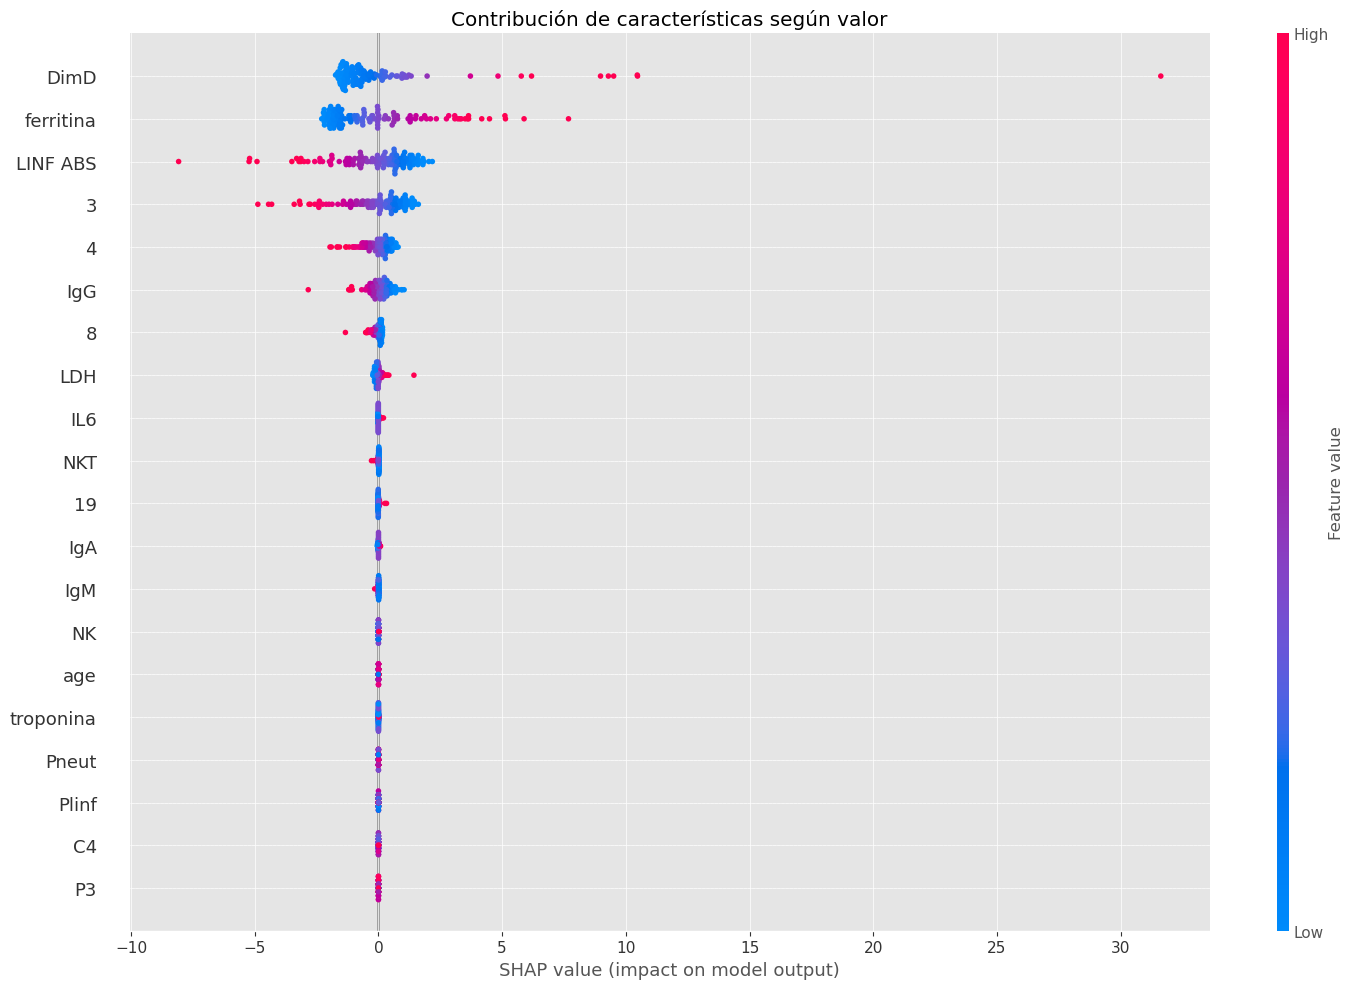

In [20]:
# Gráfico de contribución de características según valor
plt.title('Contribución de características según valor')
shap.summary_plot(shap_values, X_train, feature_names, plot_size = (15,10))